# Importing libraries

In [2]:
!pip install rpy2==2.9.6b

     |████████████████████████████████| 194kB 6.6MB/s 
  Created wheel for rpy2: filename=rpy2-2.9.6b0-cp36-cp36m-linux_x86_64.whl size=316067 sha256=495029ee7f4d9e1960f87c758fbf495a04f93f958ca3a51c44d5d276f91621ba
  Stored in directory: /root/.cache/pip/wheels/02/d6/dc/8c3faafb8cb7165a30d67f899ff7e88766e20260dda41ace88
Successfully built rpy2
  Found existing installation: rpy2 3.2.7
    Uninstalling rpy2-3.2.7:
      Successfully uninstalled rpy2-3.2.7


In [3]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [4]:
%%R
install.packages("grf")



/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘zoo’, ‘DiceKriging’, ‘lmtest’, ‘sandwich’, ‘RcppEigen’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-8.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 849487 bytes (829 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:1

In [5]:
!pip install justcause==0.3.2

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 245kB 7.0MB/s 
     |████████████████████████████████| 1.8MB 9.1MB/s 
     |████████████████████████████████| 327kB 18.5MB/s 
  Created wheel for causalml: filename=causalml-0.9.0-cp36-cp36m-linux_x86_64.whl size=482217 sha256=45daaf0af4ffd17785b876b66a54f42b4e72b05e8dd28b3fa06e4ccfa26a779e
  Stored in directory: /root/.cache/pip/wheels/6d/c4/e2/451f0ebc2f9a7540256b0a705a2fd09864893131aee58d5af9
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463916 sha256=d2df913cd43a27f03baa4a81afeddda56c612489b03297d127159e496b945ccd
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from justcause.data import Col
from justcause.data.sets import load_ihdp
from justcause.metrics import pehe_score, mean_absolute
from justcause.evaluation import calc_scores, summarize_scores

In [2]:
%load_ext autoreload

%autoreload 2

# Loading all required packages 
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Infant Health Development Program Data-Set used in this exercise

- Original study constructed to study the effect of special child care for low birthweight, premature infants.
- In total, six continuous and 19 binary pretreatment variables
- Using the covariates of all instances in both treatment groups, the potential outcomes are generated synthetically
- Finally, manipulation of observational study by omitting a non-random set of samples from the treatment group.
- The way the subset is generated from the experimental data does not ensure complete overlap - latent confounder
- Specifically, the observational subset is created by throwing away the set of all children with nonwhite mothers from the treatment group
- Following data generation process used for potentia outcomes
- After the adaptions from Hill, we are left with 139 instances in the treated group and 608 instances in the control group.

# 1. Running the causal models

In [3]:
# We Import the IHDP data-set 
# There are 1000 replications in this data-set, each with a different individual treament effect
# produced from an underlying generative function. 
# Check out https://justcause.readthedocs.io/en/latest/


# We load 100 of the 1000 data-sets
replications = load_ihdp(select_rep=np.arange(100))

In [4]:
# Defining global parameters
train_size = 0.8        # Size of the training data-set 
random_state = 42        # Setting the random state

n= 0       # number of the data-sets we look at 

metrics = [pehe_score, mean_absolute]    ## Defining the metrics that will be calculated below

```
t     => treatment (0 or 1)

y     => factual outcome

y_cf  => counterfactial outcome

y_0   => potential outcome of treatment t=0

y_1   => potential outcome of treatment t=1

ite   => indivisual treatment effect  (y_1 - y_0)

```



In [86]:
replications[0].head()

,sample_id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,t,y,mu_1,mu_0,y_cf,ite,y_0,y_1
0,0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,5.822879,1.164950,-0.298509,4.657928,1.164950,5.822879
100,1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,6.920703,3.492099,5.783770,3.428604,3.492099,6.920703
200,2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,6.821964,3.163769,7.055789,3.658195,3.163769,6.821964
300,3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,6.055371,1.469866,1.379697,4.585505,1.469866,6.055371
400,4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,6.452848,2.187257,2.747986,4.265591,2.187257,6.452848


## 1.1 S-Learner Linear Regression

In [87]:
# Importing the relevant SLearner module

from justcause.learners import SLearner


# Defining the S-Learner function that returns the ITE
# We define a function that takes the data, splits it up and returns individual treatment effect accuracies for the train and the test data-set
# The function takes each, the train and test data separately and selects the relevant variales and coverts them into np arrays
# The relevant variables have the followings names: x (the covariates), t (the treatment), y (the outcome)
# Note that the treatment needs to be explicityl defined



def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y
    
    slearner = model     # Select linear regression as a method to find the ITE for the S-Learner
    slearner.fit(train_X, train_t, train_y)      # Fitting the s-learner with linear regression
    return (
        slearner.predict_ite(train_X, train_t, train_y),   # Returning the predicting values for ITE for train
        slearner.predict_ite(test_X, test_t, test_y)       # Returning the prediction values for ITE for test
    )



In [88]:
results_df = list()     # We define the list that contains the results
test_scores = list()    # Storing the test scores in a list
train_scores = list()   # Storing the train scores in a list


# Here we define the model that is going to be used for the S-learner
# Please instantiate linear regression for the simple learner

from sklearn.linear_model import LinearRegression


##-----------------Question------------------###
# Pass a LinearRegression Model into the S-Learner
# No particular parameter-settings necessary


model=SLearner(LinearRegression())


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_slearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})

In [89]:
df_S_learner_LR=pd.DataFrame([train_result, test_result])
df_S_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False


### 1.1.1 S-Learner Visualization

In [90]:
# We run the same analysis again but only on an indvidual run of the data
# The reason is that the data generating process is varied every time,... 
# ...so we can only look at individual runs of the ITE effect
results_df = list()    # We define the list that contains the results
test_scores = list()   # Storing the test scores in a list
train_scores = list()  # Storing the train scores in a list


#for rep in replications:

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state     # Use train_test_split  to split the data-set (replications[n]) 
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_slearner(train, test, model)         # using the pre-defined basic learner function to retunr train, test

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))    # Using the just cause API to calcualte the scores from the estimate ITE for the training data
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))     # Using the just cause API to calcualte the scores from the estimate ITE for the test data

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)   #summary of the scores 
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


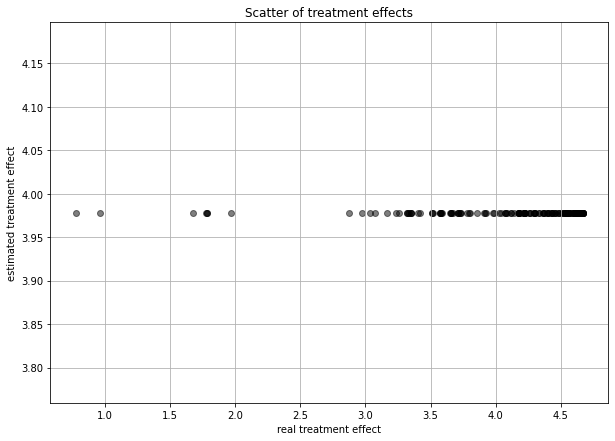

In [91]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.figure(figsize=(10, 7))
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.grid()
plt.show()

# If the treatment effect is perfectly represented there should be a 45 degree line!

## QUESTION 1

IS THE S-LEARNER WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# ANSWER 1

S-Learner with seems to be a poor estimator of ITE as it always return the same ITE no matter what the real treatment effect is. Model is predicting Average Treatement Effect but we want Indivisaul Treatment effects. 

Overall: Bad Estimation

## 1.2 Propensity Score Weighing with Linear Regression

In [120]:
# Importing the relevant PSWEstimator

from justcause.learners import PSWEstimator


#Defining the Propoensity Score weighing function that returns the ITE

def propensity_score_weighing(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    pswestimator = model

    return (
        pswestimator.estimate_ate(train_X, train_t, train_y),
        pswestimator.estimate_ate(test_X, test_t, test_y)
    )


In [121]:
results_df = list()
test_scores = list()
train_scores = list()




model = PSWEstimator(propensity_learner=None, delta=0.001)


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = propensity_score_weighing(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'PSW', 'train': True})
test_result.update({'method': 'PSW', 'train': False})

In [122]:
df_PSW_LR=pd.DataFrame([train_result, test_result])
df_PSW_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.705081,2.699761,8.205818,1.234220,0.819094,1.140432,PSW,True
1,5.695339,2.483461,8.217443,0.519767,0.482485,0.348374,PSW,False


## 1.3 S-Learner Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


# Importing the relevant S-Learner estimator
from justcause.learners import SLearner


#Defining the S-Learner function that returns the ITE

def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model  
    slearner.fit(train_X, train_t, train_y)
    return (
        slearner.predict_ite(train_X, train_t, train_y),
        slearner.predict_ite(test_X, test_t, test_y)
    )


In [6]:
results_df = list()
test_scores = list()
train_scores = list()

#---------------------------Question--------------------------------#
# Pass a RandomForestRegressor into the S-learner


model = SLearner(RandomForestRegressor())

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_slearner(train, test, model )

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner RF', 'train': True})
test_result.update({'method': 'S-Learner RF', 'train': False})

In [7]:
df_S_learner_RF=pd.DataFrame([train_result, test_result])
df_S_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,3.107685,1.053549,4.760754,0.503079,0.132801,0.934136,S-Learner RF,True
1,3.322921,1.238255,5.172362,0.446676,0.126003,1.036056,S-Learner RF,False


### 1.3.1 Random Forest Visualization

There seemed to be a problem with cell below where the professor again defined the basic_slearner function here. So i changed the code where now i am calling the basic s-learner function here.   

In [8]:
results_df = list()
test_scores = list()
train_scores = list()

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_slearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


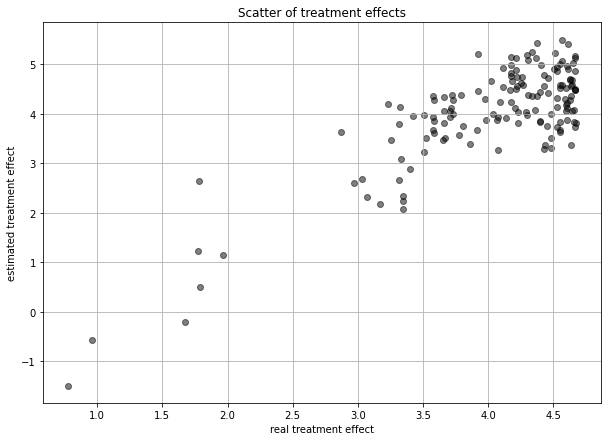

In [9]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.figure(figsize=(10, 7))
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.grid()
plt.show()

## QUESTION 2

IS THE S-LEARNER WITH RANDOM FOREST ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# ANSWER 2
1. S-learner with random forest regressor is producing better results than with Linear Regression. But still the resuts are not accurate. 

2. For 3 indivisuals i can see that the real treatment effect was positive but the model outputs negative treatment effect which can be disasterous.  

3. For several indivisuals when Real Treatment Effect is low, the model predicts high and vice versa.    

Overall: Better Estimation than Linear Regression with single learner. 



## 1.4 T-Learner Linear Regression

In [10]:
# Importing the relevant SLearner module

from justcause.learners import TLearner


#Defining the S-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [11]:
results_df = list()
test_scores = list()
train_scores = list()

#------------------Question------------------------------#
# Pass linear regression into the T-Learner

from sklearn.linear_model import LinearRegression

model = TLearner(LinearRegression())

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_tlearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

In [12]:
df_T_learner_LR=pd.DataFrame([train_result, test_result])
df_T_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.276868,1.055409,3.319402,0.149960,0.133955,0.129121,T-Learner LR,True
1,2.337753,1.122464,3.263915,0.263287,0.195850,0.327846,T-Learner LR,False


### 1.4.1 T-Learner Linear Regression Visualization

In [14]:
results_df = list()
test_scores = list()
train_scores = list()

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_tlearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


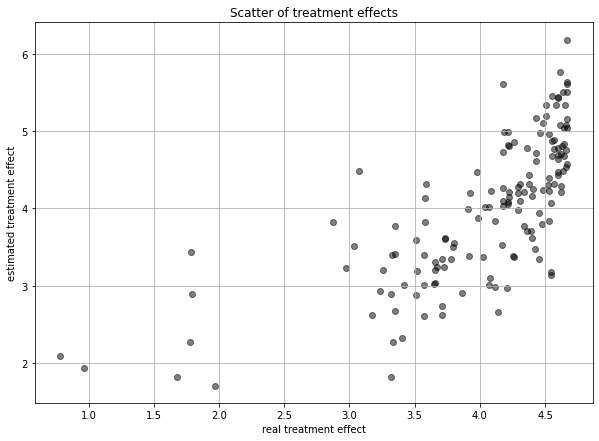

In [15]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.figure(figsize=(10, 7))
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.grid()
plt.show()

## QUESTION 3

IS THE T-LEARNER WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# ANSWER 3

For several indivisuals when Real Treatment Effect is low, the model predicts high and vice versa.  

Overall: Better estimation than S-learner with Linear Regression

## 1.5 T-Learner Random Forest

In [107]:
# Importing the relevant SLearner module

from justcause.learners import TLearner


#Defining the S-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [108]:
results_df = list()
test_scores = list()
train_scores = list()

#--------------------Question----------------------------------#
# Pass a Random Forest into the T-Learner

model = TLearner(RandomForestRegressor())

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_tlearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

In [109]:
df_T_learner_RF=pd.DataFrame([train_result, test_result])
df_T_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,1.775321,0.955023,2.232431,0.125264,0.098101,0.125193,T-Learner RF,True
1,2.508553,1.118640,3.512167,0.211167,0.123882,0.288221,T-Learner RF,False


### 1.5.1 T-Learner with Random Forrest Visualization

In [110]:
results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_tlearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


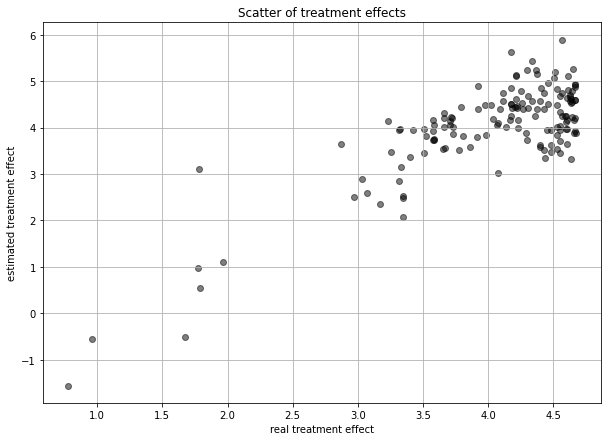

In [111]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.figure(figsize=(10, 7))
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.grid()
plt.show()

## QUESTION 4

IS THE T-LEARNER WITH RANDOM FOREST ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# ANSWER 3

1. For 3 indivisuals i can see that the real treatment effect was positive but the model outputs negative treatment effect which can be disasterous.  

2. For several indivisuals when Real Treatment Effect is low, the model predicts high and vice versa.  

Overall: Better Estimation than Linear Models

## 1.6 Causal Forest

In [112]:
# Importing the relevant SLearner module

from justcause.learners import CausalForest


#Defining the causal_forest function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    causalforest = model
    causalforest.fit(train_X, train_t, train_y)
    return (
        causalforest.predict_ite(train_X, train_t, train_y),
        causalforest.predict_ite(test_X, test_t, test_y)
    )


In [113]:
results_df = list()
test_scores = list()
train_scores = list()

model = CausalForest(random_state=random_state)

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = causal_forest(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'causal forest', 'train': True})
test_result.update({'method': 'causal forest', 'train': False})

In [114]:
df_causal_forest=pd.DataFrame([train_result, test_result])
df_causal_forest

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,4.183684,1.867887,6.357736,0.400383,0.167071,0.710400,causal forest,True
1,4.197395,1.861331,6.171123,0.773380,0.296180,1.380762,causal forest,False


### 1.6.1 Causal Forest Visualization 

In [117]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = causal_forest(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'causal forest', 'train': True})
test_result.update({'method': 'causal forest', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


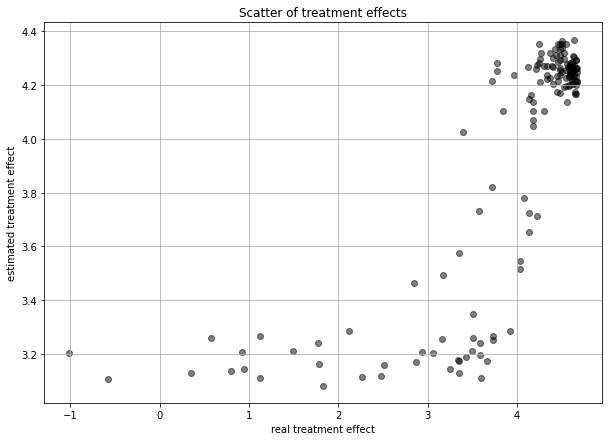

In [118]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.figure(figsize=(10, 7))
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.grid()
plt.show()

## QUESTION 5

IS THE CAUSAL FOREST WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# ANSWER 5

1. Model is always predicting positive treatment effect which is not good. We have 2 indivisuals with negative real treatment effect.

2. I can see huge deviations in estimated treatment effect from the true treatments effects.

Overall: Bad Estimation.

## 1.7 Neural Network

In [42]:
# Importing the relevant SLearner module

from justcause.learners import DragonNet


#Defining the S-Learner function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    dragonnet = model
    dragonnet.fit(train_X, train_t, train_y)
    return (
        dragonnet.predict_ite(train_X, train_t, train_y),
        dragonnet.predict_ite(test_X, test_t, test_y)
    )


In [43]:
results_df = list()
test_scores = list()
train_scores = list()


#---------------------------Question----------------------------#
# Set the model to the DragonNet neural network from JustCause


model = DragonNet(learning_rate=0.001, 
                  num_epochs=50,
                  batch_size=512,
                  validation_split=0.1)



for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = causal_forest(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 18ms/step - loss: 148391.2500 - regression_loss: 39880.6016 - val_loss: 13966.4707 - val_regression_loss: 6948.1104
Epoch 3/50
2/2 [==============================] - 0s 17ms/step - loss: 119983.9922 - regression_loss: 32907.1055 - val_loss: 10250.8330 - val_regression_loss: 5096.9053
Epoch 4/50
2/2 [==============================] - 0s 19ms/step - loss: 89767.6562 - regression_loss: 24101.8457 - val_loss: 6216.3589 - val_regression_loss: 3086.6904
Epoch 5/50
2/2 [==============================] - 0s 17ms/step - loss: 53236.3203 - regression_loss: 14363.3584 - val_loss: 3148.3289 - val_regression_loss: 1559.6901
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 24987.6055 - regression_loss: 6670.6494 - val_loss: 2967.3386 - val_regression_loss: 1474.9260
Epoch 7/50
2/2 [==============================] - 0s 15ms/step - loss: 19108.4746 - regression_loss: 5328.2710 - val_loss:

In [44]:
df_dragonnet=pd.DataFrame([train_result, test_result])
df_dragonnet

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.895922,1.147672,4.997336,0.837232,0.360654,1.772157,Dragonnet,True
1,2.989693,1.080577,4.865770,0.915148,0.361813,2.094658,Dragonnet,False


### 1.7.1 Neura Network Visualization

In [45]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = causal_forest(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

Epoch 1/50
2/2 [==============================] - 0s 173ms/step - loss: 14214.2520 - regression_loss: 3783.1951 - val_loss: 1408.0223 - val_regression_loss: 683.1639
Epoch 2/50
2/2 [==============================] - 0s 14ms/step - loss: 9455.8633 - regression_loss: 2459.1714 - val_loss: 889.2617 - val_regression_loss: 419.6762
Epoch 3/50
2/2 [==============================] - 0s 13ms/step - loss: 5815.4253 - regression_loss: 1473.8182 - val_loss: 575.0538 - val_regression_loss: 259.1024
Epoch 4/50
2/2 [==============================] - 0s 13ms/step - loss: 4030.9312 - regression_loss: 975.0330 - val_loss: 376.2782 - val_regression_loss: 163.1413
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 2584.3389 - regression_loss: 601.3830 - val_loss: 342.3614 - val_regression_loss: 152.8701
Epoch 6/50
2/2 [==============================] - 0s 17ms/step - loss: 2182.5352 - regression_loss: 512.9050 - val_loss: 472.8154 - val_regression_loss: 222.7929
Epoch 7/50
2/2 [======

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


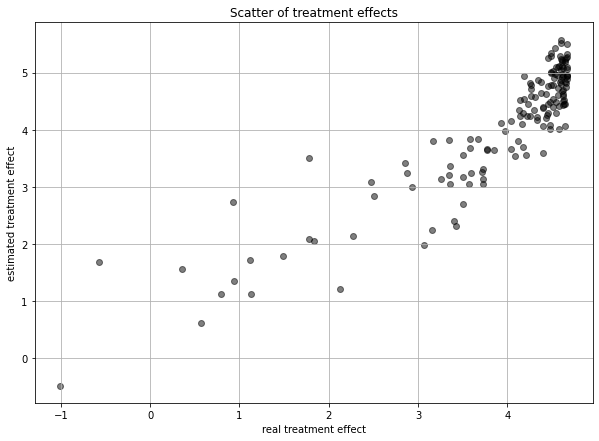

In [46]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.figure(figsize=(10, 7))
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.grid()
plt.show()

## QUESTION 6

IS THE DRAGONNET NEURAL NETWORK ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# ANSWER

1. Here again i see that for an indivisual which had negative real treatment effect the model predicted positive.

2. One indivisual with positive real treatment effect was esitimated as having negative treatment effect.

2. Estimations are scattered and i don't see 45 degree straight line.

Overall: Still better than Linear Models and causal Forest

## 1.8 Comparison of the methods

In [119]:
pd.concat([df_S_learner_LR, df_PSW_LR, df_S_learner_RF, df_T_learner_LR, df_T_learner_RF, df_causal_forest, df_dragonnet ], ignore_index=True)

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False
2,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
3,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False
4,3.105226,1.044589,4.789518,0.498694,0.129153,0.938009,S-Learner RF,True
5,3.312611,1.289761,5.139224,0.444874,0.137630,1.011833,S-Learner RF,False
6,2.276868,1.055409,3.319402,0.149960,0.133955,0.129121,T-Learner LR,True
7,2.337753,1.122464,3.263915,0.263287,0.195850,0.327846,T-Learner LR,False
8,1.775321,0.955023,2.232431,0.125264,0.098101,0.125193,T-Learner RF,True
9,2.508553,1.118640,3.512167,0.211167,0.123882,0.288221,T-Learner RF,False




```
# This is formatted as code
```

## QUESTION 7

HOW DO THE DIFFERENT MODELS COMPARE IN TERMS OF MEAN PEHE ACCURACY? WHAT ASPECTS DO YOU THINK DETERMINE WHETHER ONE MODEL PERFOMS BETTER THAN ANOTER?

# Answer
PEHE score is essentially the root mean squared error of individual treatment effects, the lower the better. 

RMSE gives more weight to large errors...

1. With default hyperparameter settings, T-Learner with Linear Regression performed the best among other causal models as it corresponds to lowest mean PEHE score on the test data.

2. Worst performer is PSWEstimator with highest PEHE score on test data. 

3. I can see that the lowest pehe_score-std is with Dragonnet, which means that the model's error was a not varing alot across the replications. 


MAE gives equal weight to large and small errors...

1. T-Learner with random forest gives the best MAE on test set. 




#  Explanations:

T-learners with powerful non-linear model (eg Random Forest) tend to outperform other models because we have different models for treatment t0 and treatment t1 and have the ability to model hetrogenious effects in the data.

In S-learner with Linear Regression there is no interaction between our covariates and treatment variable which is responsible for poor result. We can tell this just by looking at the a particular linear equation. Also, the coefficient of treatment remains same which prevents the model to capture hetrogenious effects. Results with T learner linear regression improved sigficantly as it is able to capture hetrogenious effects.  

Whereas in T-Learners we are explicitly modelling seperatly for t0 and t1 which improves the results even with Linear Regression. Theoratically same as T-learners, DragonNet is a three-headed architecture where from a common representation layer Z the network divides and half of the network learns to model for t=0 and the other t=1.